# TDoA Localization with Technical Delays

This notebook simulates TDOA (Time Difference of Arrival) localization with varying technical delays.
We have:
- 1 TX (transmitter/drone)
- 4 RX (receivers/nodes)
- Technical delays from 0.001 ns to 10000 ns added to true propagation delays

The simulation shows how technical timing errors affect localization accuracy.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add parent directories to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
sys.path.insert(0, str(project_root))

from src.core import (
    solve_tdoa_pairwise,
    generate_pairwise_tdoa,
    plot_hyperbola_2d,
    get_bounds,
)
from simulation.tdoa_sim import all_pairs

print("Imports successful!")

Imports successful!


## Setup: Define TX and RX Positions

In [86]:
import geopandas as gpd
from shapely.geometry import Point

# Center coordinates (lat, lon)
center_coords = (46.6354, 32.6169)

# Define 4 receiver nodes (RX) in a square pattern - 1km spacing
nodes_latlon = np.array([
    [46.6354 - 0.009, 32.6169 - 0.014],  # N0: ~1km south-west
    [46.6354 - 0.009, 32.6169 + 0.014],  # N1: ~1km south-east
    [46.6354 + 0.009, 32.6169 + 0.014],  # N2: ~1km north-east
    [46.6354 + 0.009, 32.6169 - 0.014]   # N3: ~1km north-west
])

# Convert lat/lon to meters (Web Mercator projection EPSG:3857)
gdf_nodes = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lat, lon in nodes_latlon],
    crs="EPSG:4326"
).to_crs(epsg=3857)

nodes = np.array([(p.x, p.y) for p in gdf_nodes.geometry])

# True transmitter position (TX/drone) - slightly offset from center
true_tx_latlon = np.array([46.6354 + 0.003, 32.6169 - 0.005])  # ~300m north, 400m west
gdf_tx = gpd.GeoDataFrame(
    geometry=[Point(true_tx_latlon[1], true_tx_latlon[0])],
    crs="EPSG:4326"
).to_crs(epsg=3857)

true_tx = np.array([gdf_tx.geometry.iloc[0].x, gdf_tx.geometry.iloc[0].y])

# Speed of light (m/s)
c = 3e8

print(f"Nodes (RX) in Web Mercator (meters): \n{nodes}")
print(f"\nNode spacing: ~1000m between adjacent nodes")
print(f"\nTrue TX position (meters): {true_tx}")
print(f"\nNumber of receiver pairs: {len(all_pairs(4))}")

Nodes (RX) in Web Mercator (meters): 
[[3629338.22638402 5881304.82928347]
 [3632455.17212623 5881304.82928347]
 [3632455.17212623 5884223.03290048]
 [3629338.22638402 5884223.03290048]]

Node spacing: ~1000m between adjacent nodes

True TX position (meters): [3630340.10180116 5883250.1905036 ]

Number of receiver pairs: 6


## Define Technical Delay Range

Technical delays represent systematic timing errors in the receiver system (clock drift, processing delays, etc.)

In [ ]:
# Technical delays from 0.001 ns to 10000 ns
# Convert to seconds for simulation
tech_delays_ns = np.linspace(0.001, 100.0, 50)  # 50 steps from 0.001 to 10000 ns
tech_delays_s = tech_delays_ns * 1e-9  # Convert to seconds

print(f"Number of simulations: {len(tech_delays_s)}")
print(f"Technical delay range: {tech_delays_ns[0]:.4f} ns to {tech_delays_ns[-1]:.4f} ns")
print(f"Technical delay range: {tech_delays_s[0]:.4e} s to {tech_delays_s[-1]:.4e} s")
print(f"\nEquivalent distance error range: {tech_delays_s[0]*c:.4e} m to {tech_delays_s[-1]*c:.4e} m")

Number of simulations: 50
Technical delay range: 0.0010 ns to 10000.0000 ns
Technical delay range: 1.0000e-12 s to 1.0000e-05 s

Equivalent distance error range: 3.0000e-04 m to 3.0000e+03 m


## Simulation Function

In [88]:
def simulate_tdoa_with_tech_delay(nodes, true_tx, tech_delay_s, c=3e8):
    """
    Simulate TDOA localization with technical delay.
    
    Args:
        nodes: (N,2) receiver positions
        true_tx: (2,) true transmitter position
        tech_delay_s: technical delay in seconds to add to measurements
        c: speed of light (m/s)
    
    Returns:
        est_tx: estimated transmitter position
        pairs_dt: list of (i, j, dt) measurements
        error_m: localization error in meters
    """
    # Generate all receiver pairs
    pairs = all_pairs(nodes.shape[0])
    
    # Calculate true time differences (no noise)
    pairs_dt = generate_pairwise_tdoa(
        nodes, true_tx, pairs=pairs, c=c, sigma_t=0.0, seed=None
    )
    
    # Add technical delay to each measurement
    # Technical delay affects all measurements systematically
    pairs_dt_with_delay = [
        (i, j, dt + tech_delay_s) for (i, j, dt) in pairs_dt
    ]
    
    # Estimate position using TDOA solver
    est_tx, res = solve_tdoa_pairwise(
        nodes, pairs_dt_with_delay, c=c, x0=None, loss="soft_l1"
    )
    
    # Calculate error
    error_m = np.linalg.norm(est_tx - true_tx)
    
    return est_tx, pairs_dt_with_delay, error_m

print("Simulation function defined.")

Simulation function defined.


## Run Simulations for All Technical Delays

In [89]:
# Store results
results = []

for tech_delay_s in tech_delays_s:
    est_tx, pairs_dt, error_m = simulate_tdoa_with_tech_delay(
        nodes, true_tx, tech_delay_s, c=c
    )
    results.append({
        'tech_delay_s': tech_delay_s,
        'tech_delay_ns': tech_delay_s * 1e9,
        'est_tx': est_tx,
        'pairs_dt': pairs_dt,
        'error_m': error_m
    })

print(f"Completed {len(results)} simulations.")
print(f"\nError range: {min(r['error_m'] for r in results):.3f} m to {max(r['error_m'] for r in results):.3f} m")

Completed 50 simulations.

Error range: 0.000 m to 8805538.069 m


## Analyze Error vs Technical Delay

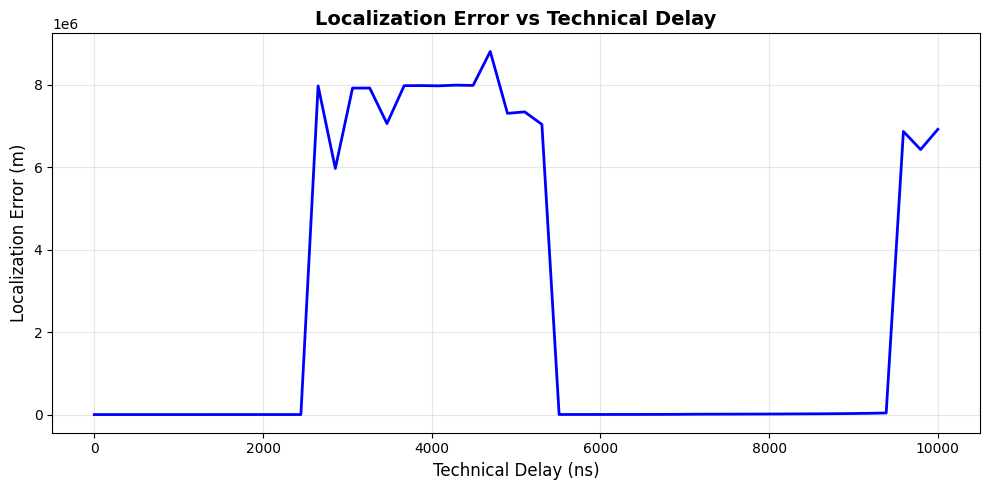


Statistics:
Min error: 0.000 m at 0.0010 ns
Max error: 8805538.069 m at 4693.8781 ns
Mean error: 2553616.725 m


In [90]:
fig, ax = plt.subplots(figsize=(10, 5))

tech_delays_plot = [r['tech_delay_ns'] for r in results]
errors_plot = [r['error_m'] for r in results]

ax.plot(tech_delays_plot, errors_plot, 'b-', linewidth=2)
ax.set_xlabel('Technical Delay (ns)', fontsize=12)
ax.set_ylabel('Localization Error (m)', fontsize=12)
ax.set_title('Localization Error vs Technical Delay', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"Min error: {min(errors_plot):.3f} m at {tech_delays_plot[np.argmin(errors_plot)]:.4f} ns")
print(f"Max error: {max(errors_plot):.3f} m at {tech_delays_plot[np.argmax(errors_plot)]:.4f} ns")
print(f"Mean error: {np.mean(errors_plot):.3f} m")

## Visualization Function with Hyperbolas

In [91]:
def plot_tdoa_scene(nodes, true_tx, est_tx, pairs_dt, tech_delay_ns, error_m, show_hyperbolas=True):
    """
    Plot TDOA localization scene with nodes, true TX, estimated TX, and hyperbolas.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set bounds based on nodes and true TX only (not estimated TX which can be very far)
    # This prevents extreme zoom when estimated position is off by kilometers
    xmin, xmax, ymin, ymax = get_bounds(nodes, extra_points=(true_tx,))
    
    # Expand bounds to make nodes look smaller - 4x scale
    # First get center
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    
    # Calculate ranges and multiply by 4
    x_range = (xmax - xmin) * 4
    y_range = (ymax - ymin) * 4
    
    # Set new bounds centered around the original center
    xmin = x_center - x_range / 2
    xmax = x_center + x_range / 2
    ymin = y_center - y_range / 2
    ymax = y_center + y_range / 2
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Plot receiver nodes
    ax.scatter(nodes[:, 0], nodes[:, 1], c='blue', marker='o', s=150, 
               label='RX Nodes', zorder=5, edgecolors='black', linewidths=2)
    for k, p in enumerate(nodes):
        ax.text(p[0] + 50, p[1] + 50, f'N{k}', color='blue', 
                fontsize=12, fontweight='bold')
    
    # Plot true TX position
    ax.scatter([true_tx[0]], [true_tx[1]], c='green', marker='*', s=300, 
               label='True TX', zorder=6, edgecolors='black', linewidths=2)
    
    # Only plot estimated TX if it's within reasonable bounds
    if xmin <= est_tx[0] <= xmax and ymin <= est_tx[1] <= ymax:
        ax.scatter([est_tx[0]], [est_tx[1]], c='red', marker='x', s=200, 
                   label=f'Estimated TX', zorder=6, linewidths=3)
        # Draw line between true and estimated
        ax.plot([true_tx[0], est_tx[0]], [true_tx[1], est_tx[1]], 
                'k--', linewidth=1, alpha=0.5, zorder=3)
    else:
        # Show direction to estimated TX with arrow
        dx = est_tx[0] - true_tx[0]
        dy = est_tx[1] - true_tx[1]
        dist = np.sqrt(dx**2 + dy**2)
        # Normalize and scale arrow
        arrow_len = min(x_range, y_range) * 0.3
        dx_norm = (dx / dist) * arrow_len
        dy_norm = (dy / dist) * arrow_len
        ax.arrow(true_tx[0], true_tx[1], dx_norm, dy_norm,
                head_width=arrow_len*0.2, head_length=arrow_len*0.15,
                fc='red', ec='red', alpha=0.6, zorder=4,
                label=f'Est. TX (off-screen, {error_m/1000:.1f} km away)')
    
    # Plot hyperbolas if requested
    if show_hyperbolas:
        for (i, j, dt) in pairs_dt:
            try:
                plot_hyperbola_2d(
                    ax, nodes[i], nodes[j], dt, c=c,
                    xlim=(xmin, xmax), ylim=(ymin, ymax),
                    grid=400, alpha=0.4
                )
            except Exception:
                pass
    
    ax.set_aspect('equal')
    ax.set_xlabel('X (meters, Web Mercator)', fontsize=12)
    ax.set_ylabel('Y (meters, Web Mercator)', fontsize=12)
    ax.set_title(
        f'TDoA Localization\n' +
        f'Technical Delay: {tech_delay_ns:.4f} ns | Error: {error_m:.3f} m',
        fontsize=13, fontweight='bold'
    )
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    return fig, ax

print("Visualization function defined.")

Visualization function defined.


## Example Visualization (First and Last Delays)

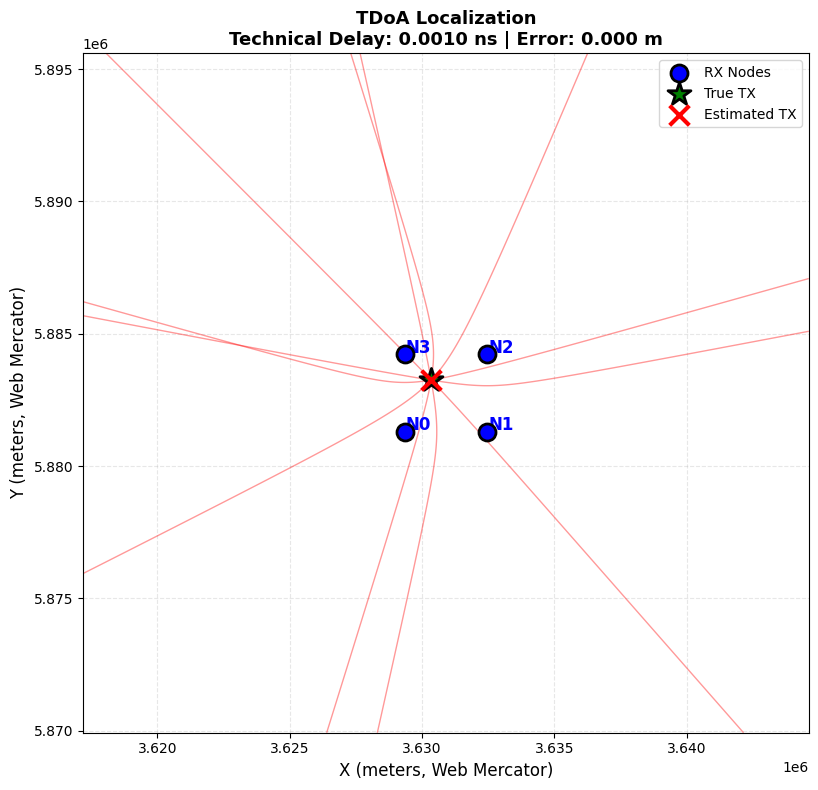

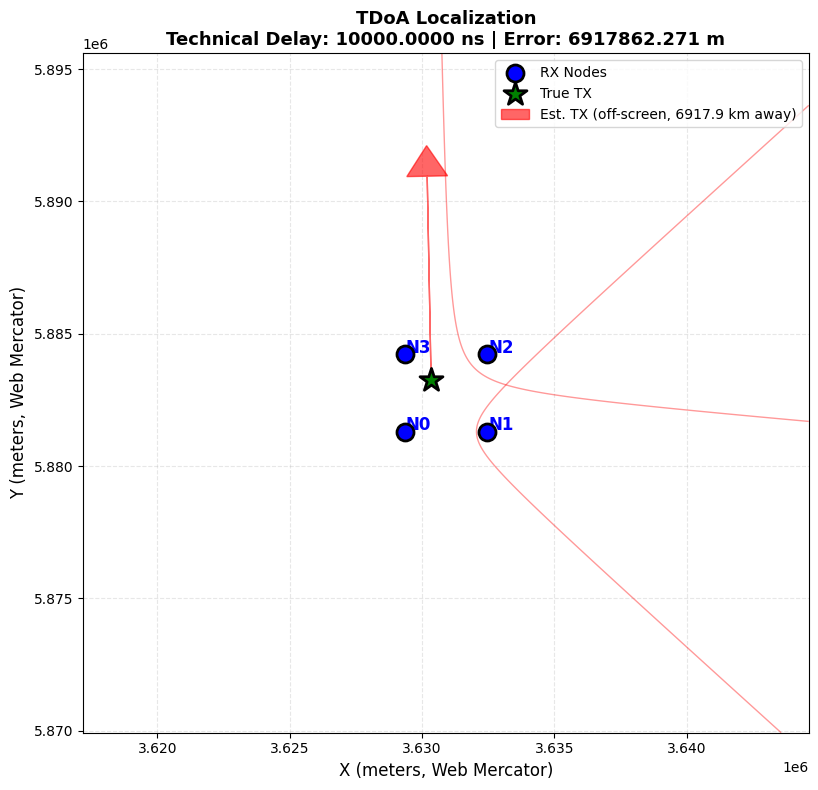

In [92]:
# Plot first case (smallest technical delay)
result_first = results[0]
plot_tdoa_scene(
    nodes, true_tx, result_first['est_tx'], result_first['pairs_dt'],
    result_first['tech_delay_ns'], result_first['error_m'],
    show_hyperbolas=True
)
plt.show()

# Plot last case (largest technical delay)
result_last = results[-1]
plot_tdoa_scene(
    nodes, true_tx, result_last['est_tx'], result_last['pairs_dt'],
    result_last['tech_delay_ns'], result_last['error_m'],
    show_hyperbolas=True
)
plt.show()

## Generate Animated GIF

Create an animated GIF showing how hyperbolas and estimated position change with technical delay.

In [93]:
# Install imageio if needed
try:
    import imageio
except ImportError:
    print("Installing imageio...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imageio"])
    import imageio

print("imageio is available.")

imageio is available.


In [94]:
import imageio.v2 as iio
from io import BytesIO

# Generate frames for GIF
print("Generating frames for GIF...")
frames = []

# Sample results for 100 second animation
# Use 50 frames for reasonable file size (100s / 50 frames = 2.0s per frame)
sample_indices = np.linspace(0, len(results)-1, 50, dtype=int)

for idx in sample_indices:
    result = results[idx]
    
    fig, ax = plot_tdoa_scene(
        nodes, true_tx, result['est_tx'], result['pairs_dt'],
        result['tech_delay_ns'], result['error_m'],
        show_hyperbolas=True
    )
    
    # Force figure to draw with consistent dimensions
    fig.canvas.draw()
    
    # Save figure to buffer with fixed size
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0.1)
    buf.seek(0)
    
    # Read image from buffer
    frame = iio.imread(buf)
    
    # Ensure consistent frame size by cropping/padding if needed
    if len(frames) > 0:
        # Match dimensions to first frame
        target_shape = frames[0].shape
        if frame.shape != target_shape:
            # Create a new frame with target shape
            new_frame = np.ones(target_shape, dtype=frame.dtype) * 255
            # Copy the smaller dimensions
            h = min(frame.shape[0], target_shape[0])
            w = min(frame.shape[1], target_shape[1])
            new_frame[:h, :w] = frame[:h, :w]
            frame = new_frame
    
    frames.append(frame)
    
    plt.close(fig)
    buf.close()
    
    if (idx + 1) % 10 == 0:
        print(f"  Generated {idx + 1} / {len(sample_indices)} frames")

print(f"\nTotal frames generated: {len(frames)}")
print(f"Frame dimensions: {frames[0].shape}")

Generating frames for GIF...
  Generated 10 / 50 frames
  Generated 20 / 50 frames
  Generated 30 / 50 frames
  Generated 40 / 50 frames
  Generated 50 / 50 frames

Total frames generated: 50
Frame dimensions: (790, 818, 4)


In [95]:
# Save GIF
output_path = notebook_dir / 'tdoa_technical_delay.gif'

print(f"Saving GIF to: {output_path}")
# 50 frames * 2.0s per frame = 100 seconds total
iio.mimsave(output_path, frames, duration=2.0, loop=0)

print(f"\nGIF saved successfully!")
print(f"File size: {output_path.stat().st_size / 1024:.1f} KB")
print(f"Number of frames: {len(frames)}")

print(f"Duration per frame: 2.0 seconds")
print(f"Total duration: {len(frames) * 2.0:.1f} seconds")

Saving GIF to: c:\Users\vlady\Desktop\built-for-ukraine\drone_detection_rf_2026\drone_detection_rf_2026\docs\notebooks\tdoa_technical_delay.gif

GIF saved successfully!
File size: 1008.5 KB
Number of frames: 50
Duration per frame: 2.0 seconds
Total duration: 100.0 seconds


## Display GIF in Notebook

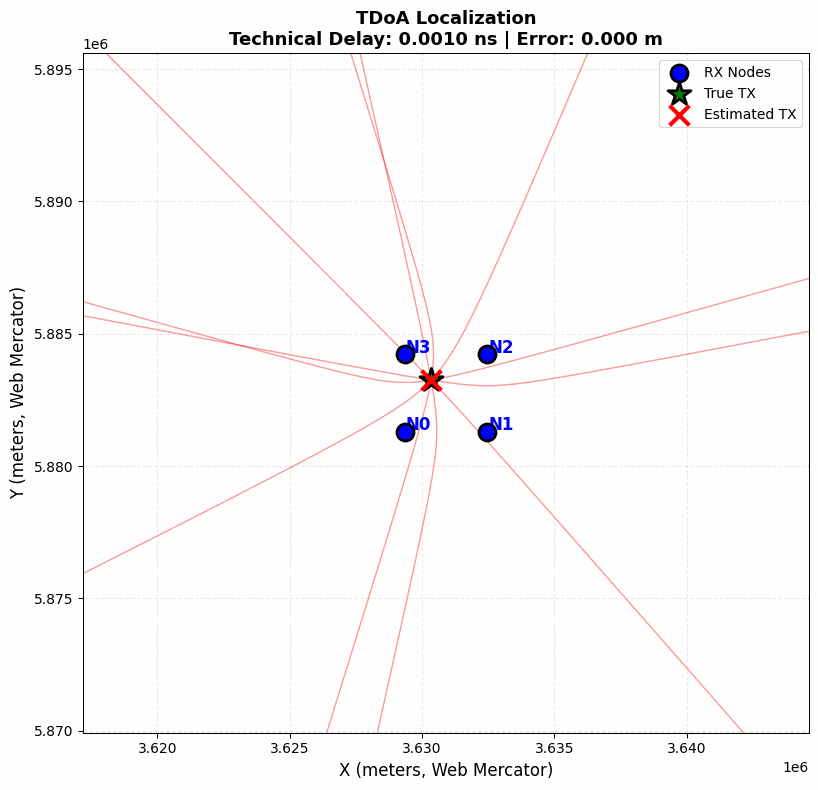

In [96]:
from IPython.display import Image, display

# Display the generated GIF
display(Image(filename=str(output_path)))

## Summary

This notebook demonstrates:

1. **TDOA Localization Setup**: 4 receiver nodes (RX) and 1 transmitter (TX)
2. **Technical Delay Effects**: Systematic timing errors from 0.001 ns to 10000 ns
3. **Error Analysis**: How technical delays affect localization accuracy
4. **Hyperbola Visualization**: Shows the geometric constraints from TDOA measurements
5. **Animated GIF**: Visual demonstration of how hyperbolas shift with technical delay

**Key Findings**:
- Even small technical delays (nanoseconds) can cause significant localization errors (meters)
- The relationship between technical delay and error is generally non-linear
- Hyperbolas shift as technical delays change, causing the intersection point (estimated TX) to move
- Accurate timing synchronization is critical for TDOA systems